# 2021 Kharisudin et al. CNN Softmax 90.00

In [1]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snsZ

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_recall_fscore_support
)

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.hub import load_state_dict_from_url
from torchvision import models


import math
from inspect import isfunction
import torch
import torch.nn as nn
import torch.nn.functional as F


import warnings
warnings.filterwarnings(
    "ignore", 
    category=UserWarning, 
    module="torchvision.models._utils"
)

In [2]:
class CFG:
    EPOCHS = 30
    BATCH_SIZE = 32
    SEED = 42
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [3]:
def seed_everything(seed=CFG.SEED):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable optimization for reproducibility

seed_everything(CFG.SEED)

In [4]:
# Define paths
DATASET_PATH = "/kaggle/input/skin-cancer-malignant-vs-benign/"
TRAIN_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/train/'
TEST_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/test/'

In [5]:
%%time
train_images = glob.glob(f"{TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{TEST_PATH}**/*.jpg")

CPU times: user 6.52 ms, sys: 3.94 ms, total: 10.5 ms
Wall time: 57.3 ms


In [6]:
# Get train & test set sizes
train_size = len(train_images)
test_size = len(test_images)

# Get dataset size
total = train_size + test_size

# View samples counts
print(f'train samples count:\t\t{train_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		2637
test samples count:		660
TOTAL:				3297


In [7]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Modified version with proper error checking
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    
    # Add print statement to verify unique labels
    print("Unique labels before encoding:", df['label'].unique())
    
    # Modified label encoding with value counts
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)
    print("Label distribution after encoding:", df['label_encoded'].value_counts())
    
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [8]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

Unique labels before encoding: ['benign' 'malignant']
Label distribution after encoding: label_encoded
1    1440
0    1197
Name: count, dtype: int64
Unique labels before encoding: ['benign' 'malignant']
Label distribution after encoding: label_encoded
1    360
0    300
Name: count, dtype: int64


In [9]:
new_test_df = test_df.sample(n=330, random_state=CFG.SEED)
remaining_test_df = test_df.drop(new_test_df.index) 
train_df = pd.concat([train_df, remaining_test_df], ignore_index=True)
test_df = new_test_df

In [10]:
# Create Train/Val split with Training Set
val_size = 330
test_size = val_size / len(train_df)
train_split_idx, val_split_idx, _, _ = train_test_split(train_df.index, 
                                                        train_df.label_encoded, 
                                                        test_size=test_size,
                                                        stratify=train_df.label_encoded,
                                                        random_state=CFG.SEED)

In [11]:
# Get new training and validation data
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

# View shapes
train_new_df.shape, val_df.shape, test_df.shape

((2637, 3), (330, 3), (330, 3))

In [13]:
class SkinCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label_encoded']
        image = Image.open(img_path).convert('RGB')  # Ensure it's RGB

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms (resize, normalize, augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create PyTorch datasets
train_dataset = SkinCancerDataset(train_new_df, transform=train_transforms)
val_dataset = SkinCancerDataset(val_df, transform=val_transforms)
test_dataset = SkinCancerDataset(test_df, transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)


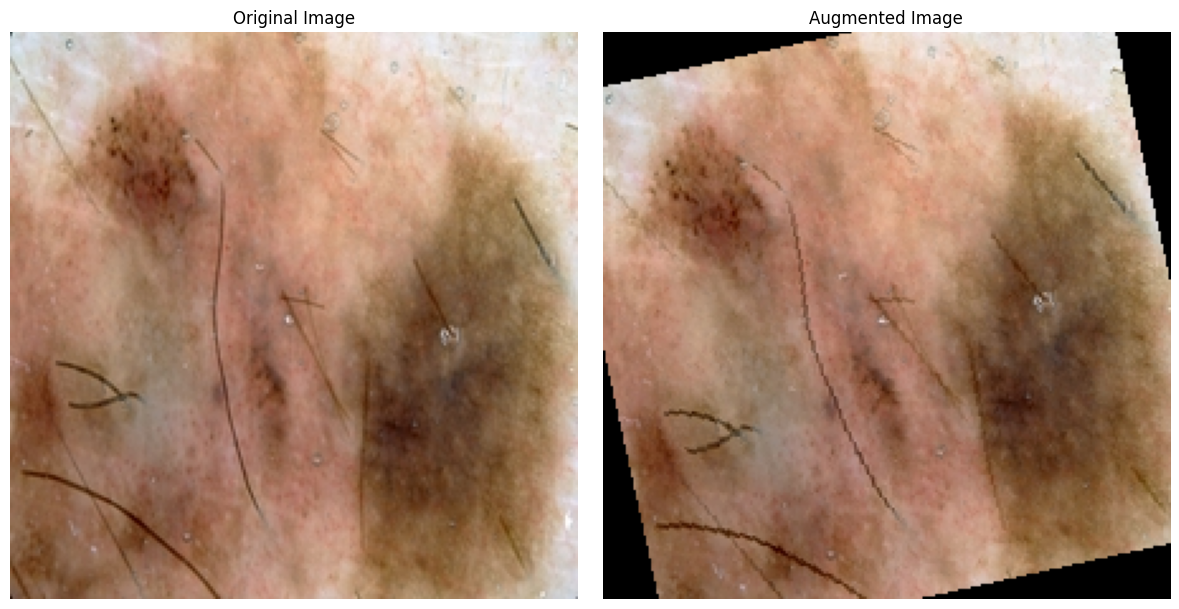

In [14]:
def show_original_and_augmented(dataset, idx, transform, fig_size=(12, 6)):
    """
    Display the original image and the augmented image side by side.
    
    Parameters:
    - dataset: The dataset containing images and labels.
    - idx: Index of the image to display.
    - transform: The transformation pipeline to apply to the image.
    - fig_size: Tuple for figure size.
    """
    # Load the original image and label
    img_path = dataset.df.iloc[idx]['image_path']
    original_image = Image.open(img_path).convert('RGB')  # Ensure it's RGB
    
    # Apply the transform to create the augmented image
    augmented_image = transform(original_image)
    
    # Convert both images to numpy arrays for visualization
    original_image_np = np.array(original_image)
    augmented_image_np = augmented_image.permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    augmented_image_np = np.clip(augmented_image_np * np.array([0.229, 0.224, 0.225]) + 
                                 np.array([0.485, 0.456, 0.406]), 0, 1)  # Denormalize
    
    # Plot side by side
    plt.figure(figsize=fig_size)
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np)
    plt.title("Original Image")
    plt.axis('off')
    
    # Augmented image
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image_np)
    plt.title("Augmented Image")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Example usage
random_idx = random.randint(0, len(train_dataset) - 1)  # Get a random index
show_original_and_augmented(train_dataset, random_idx, transform=train_transforms)

# Model CNN

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class SkinCancerCNN(nn.Module):
    def __init__(self):
        super(SkinCancerCNN, self).__init__()
        
        # First conv block (224x224x8)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 112x112x8
        )
        
        # Second conv block (112x112x8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 56x56x8
        )
        
        # Third conv block (56x56x32)
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28x32
        )
        
        # Fourth conv block (28x28x32)
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14x32
        )
        
        self.dropout1 = nn.Dropout(0.5)
        
        # Flatten and dense layers
        self.fc1 = nn.Linear(14 * 14 * 32, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: benign and malignant
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.softmax(self.fc2(x))
        return x

In [19]:
model = SkinCancerCNN()
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

815594


In [20]:
import torch
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SkinCancerCNN().to(device)  
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             224
              ReLU-2          [-1, 8, 224, 224]               0
         MaxPool2d-3          [-1, 8, 112, 112]               0
              ReLU-4          [-1, 8, 112, 112]               0
            Conv2d-5          [-1, 8, 112, 112]             584
              ReLU-6          [-1, 8, 112, 112]               0
         MaxPool2d-7            [-1, 8, 56, 56]               0
              ReLU-8            [-1, 8, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           2,336
             ReLU-10           [-1, 32, 56, 56]               0
        MaxPool2d-11           [-1, 32, 28, 28]               0
             ReLU-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 32, 28, 28]           9,248
             ReLU-14           [-1, 32,

In [20]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.00001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = running_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    torch.save(model.state_dict(), 'skin_cancer_model.pth')
    return train_losses, train_accuracies, val_losses, val_accuracies

# Training with DATA AUGMENTATION 

In [21]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, num_epochs=100, learning_rate=0.00001
    )

Epoch [1/100]
Train Loss: 0.6909, Train Acc: 54.30%
Val Loss: 0.6910, Val Acc: 54.24%
Epoch [2/100]
Train Loss: 0.6901, Train Acc: 54.30%
Val Loss: 0.6903, Val Acc: 54.24%
Epoch [3/100]
Train Loss: 0.6892, Train Acc: 54.30%
Val Loss: 0.6893, Val Acc: 54.24%
Epoch [4/100]
Train Loss: 0.6878, Train Acc: 54.30%
Val Loss: 0.6876, Val Acc: 54.24%
Epoch [5/100]
Train Loss: 0.6859, Train Acc: 54.42%
Val Loss: 0.6851, Val Acc: 55.76%
Epoch [6/100]
Train Loss: 0.6834, Train Acc: 55.48%
Val Loss: 0.6816, Val Acc: 56.36%
Epoch [7/100]
Train Loss: 0.6787, Train Acc: 56.92%
Val Loss: 0.6772, Val Acc: 59.70%
Epoch [8/100]
Train Loss: 0.6740, Train Acc: 58.89%
Val Loss: 0.6717, Val Acc: 60.91%
Epoch [9/100]
Train Loss: 0.6689, Train Acc: 59.76%
Val Loss: 0.6658, Val Acc: 63.33%
Epoch [10/100]
Train Loss: 0.6618, Train Acc: 61.43%
Val Loss: 0.6591, Val Acc: 64.85%
Epoch [11/100]
Train Loss: 0.6557, Train Acc: 62.19%
Val Loss: 0.6530, Val Acc: 64.55%
Epoch [12/100]
Train Loss: 0.6493, Train Acc: 63.29%

In [50]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(all_labels, all_preds)
    print('\nConfusion Matrix:')
    print(cm)
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))
    
    return accuracy, cm

model.load_state_dict(torch.load('skin_cancer_model.pth', weights_only =False))
model = model.to(device)
accuracy, confusion_matrix = test_model(model, test_loader, device)

Test Accuracy: 78.48%

Confusion Matrix:
[[128  13]
 [ 58 131]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.69      0.91      0.78       141
   Malignant       0.91      0.69      0.79       189

    accuracy                           0.78       330
   macro avg       0.80      0.80      0.78       330
weighted avg       0.82      0.78      0.79       330



# Training Without DATA AUGMENTATION

In [51]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.00001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = running_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    torch.save(model.state_dict(), 'skin_cancer_model_1.pth')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [52]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, num_epochs=100, learning_rate=0.00001
    )

Epoch [1/100]
Train Loss: 0.4963, Train Acc: 81.15%
Val Loss: 0.5052, Val Acc: 80.30%
Epoch [2/100]
Train Loss: 0.4968, Train Acc: 80.93%
Val Loss: 0.5042, Val Acc: 80.91%
Epoch [3/100]
Train Loss: 0.4953, Train Acc: 81.19%
Val Loss: 0.5032, Val Acc: 80.91%
Epoch [4/100]
Train Loss: 0.4969, Train Acc: 81.15%
Val Loss: 0.5053, Val Acc: 79.70%
Epoch [5/100]
Train Loss: 0.4958, Train Acc: 81.42%
Val Loss: 0.5028, Val Acc: 80.91%
Epoch [6/100]
Train Loss: 0.4937, Train Acc: 81.11%
Val Loss: 0.5026, Val Acc: 81.52%
Epoch [7/100]
Train Loss: 0.4927, Train Acc: 81.80%
Val Loss: 0.5015, Val Acc: 80.61%
Epoch [8/100]
Train Loss: 0.4930, Train Acc: 81.34%
Val Loss: 0.5013, Val Acc: 81.52%
Epoch [9/100]
Train Loss: 0.4945, Train Acc: 81.19%
Val Loss: 0.5022, Val Acc: 80.00%
Epoch [10/100]
Train Loss: 0.4921, Train Acc: 81.46%
Val Loss: 0.5015, Val Acc: 80.30%
Epoch [11/100]
Train Loss: 0.4939, Train Acc: 81.34%
Val Loss: 0.5004, Val Acc: 81.52%
Epoch [12/100]
Train Loss: 0.4932, Train Acc: 81.38%

In [53]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(all_labels, all_preds)
    print('\nConfusion Matrix:')
    print(cm)
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))
    
    return accuracy, cm

model.load_state_dict(torch.load('skin_cancer_model_1.pth', weights_only =False))
model = model.to(device)
accuracy, confusion_matrix = test_model(model, test_loader, device)

Test Accuracy: 80.61%

Confusion Matrix:
[[121  20]
 [ 44 145]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.73      0.86      0.79       141
   Malignant       0.88      0.77      0.82       189

    accuracy                           0.81       330
   macro avg       0.81      0.81      0.81       330
weighted avg       0.82      0.81      0.81       330

